# Lecture 17: The sledgehammer approach to the latitude EBM

The goal of this script is to compute steady-state solutions for the latitude EBM introduced in lectures using the 'sledgehammer' approach of Newton's method. We will find that, although this works, it is highly dependent on starting with the correct initial guess. 

We seek the steady-state solutions via 
$$
T* = \Phi(T*) = \frac{Q s(y)[1 - a(T*)] - A + k\bar{T^*}}{B + k}
$$

Set the parameters according to those given in lectures

The solution converged.
0.9476557762157372
-10.00000000000025


/var/folders/lw/7v5bfgnj6gj4qhr6fykhcp3h0000gn/T/ipykernel_12724/2365918122.py:47: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  I = np.trapz(T, y)


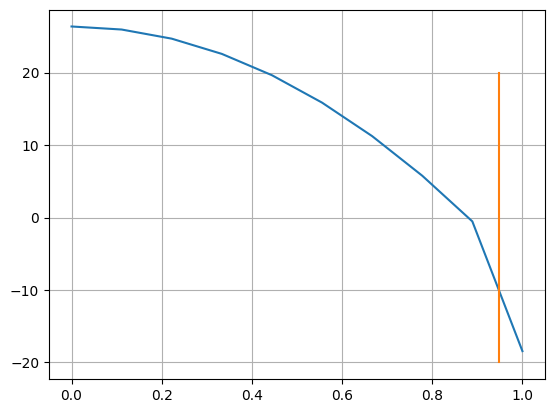

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import sys, time

A = 202 # outgoing radiation
B = 1.9 # outgoing radiation
k = 1.6*B # transport parameter
s = lambda y: 1 - 0.482*(3*y**2 - 1)/2 # solar weighting
aw = 0.32 # water albedo
ai = 0.62 # ice albedo
Tc = -10.0 # critical temperature for ice formation
Q = 342.0 # solar constant (1380 W/m^2 divided by 4)

# Below done with the help of genAI: 
# In Python with numpy, I want to create a discretisation of the interval from 0 to 1 inclusive. However, the interval points must always contain the point ys (specified between 0 and 1). And the points should ideally be equally spaced with a fixed number of points N. 
def discretize_with_fixed_point(N, ys):
    # Ensure ys is within the valid range
    if not (0 <= ys <= 1):
        raise ValueError("ys must be between 0 and 1")

    # Generate N-1 points using linspace, ensuring 0 and 1 are included
    points = np.linspace(0, 1, N)

    # If ys is already in points (within a small tolerance), return as is
    if np.isclose(points, ys).any():
        return points

    # Insert ys and sort
    points = np.append(points, ys)
    points = np.sort(points)

    # Find the closest point to ys, excluding 0 and 1
    interior_indices = np.where((points != 0) & (points != 1))[0]  # Exclude 0 and 1
    idx_to_remove = interior_indices[np.argmin(np.abs(points[interior_indices] - ys))]

    # Remove the selected point to maintain N points
    points = np.delete(points, idx_to_remove)

    return points


def Tbar(y, T):
    # Riemann sum approximation of the integral T(y) over y    
    I = 0
    I = np.trapz(T, y)
    # for i in range(0, np.size(y)-1):
    #     dy = y[i+1] - y[i]
    #     I = I + T[i]*dy
    #     # print(i, yi, T[i])
    #     # I = I + 0.5*(T[i] + T[i+1])*dy
    return I

def afunc(y, ys): 
    # Non-smooth albedo function
    a = 0*y
    for i, yy in enumerate(y):
        if yy < ys:
            aa = ai
        elif yy > ys:
            aa = aw
        else:
            aa = (ai+aw)/2
        a[i] = aa
    return a

def afunc2(y, ys):     
    a = 0*y    
    a = (aw + ai)/2 + (ai-aw)/2*np.tanh(100*(y-ys))
    return a

def myPhi(T, y, ys):
    Tb = Tbar(y, T)
    Phi = (k*Tb + Q*s(y)*(1 - afunc2(y, ys)) - A)/(B+k)
    return Phi

def myF(X):
    N = len(X)-1
    T =  X[0:N]
    ys = X[N]

    # Create a mesh appropriate for the iceline
    points = discretize_with_fixed_point(N, ys)    
    
    Phi = myPhi(T, y, ys)    
    F = np.zeros(N+1)
    F[0:N] = T - Phi
    F[N] = np.interp(ys, y, T) - Tc
    
    return F


# Initialise the mesh with N points
N = 10
y = np.linspace(0, 1, N)

# Iterative scheme
# Form an initial guess 
# Try this one for the fake solution
Tequator = 20; Tpole = -12;
T = Tequator + (Tpole - Tequator)*y
guess = np.append(T, 0.95)

# Run the solver
fwd = lambda X: myF(X)
sol, info, ier, msg = fsolve(fwd, guess, full_output=1)
print(msg)
T = sol[0:N]
ys = sol[N]
y = np.linspace(0, 1, N)
print(ys)
print(np.interp(ys,y,T))
plt.plot(y, sol[0:N])
plt.plot([ys, ys], [-20, 20])
plt.grid(1)
# # Plot the output
# solT = sol.x;
# fig = plt.figure(figsize=(6,4))
# plt.plot(y, solT, '-o')
# plt.xlabel('y'); plt.ylabel('T')
# plt.title("Mean temperature = %1.3f" % Tbar(y, solT));